# [10주차] 비선형 문제 해결사: 결정 트리와 랜덤 포레스트 🌳🌲

안녕하세요! 10주차 수업에 오신 것을 환영합니다.  
지난 시간까지 우리는 선형 회귀와 로지스틱 회귀, 즉 **선형 모델**을 배웠습니다.  
이 모델들은 데이터의 관계를 하나의 '직선' 또는 '평면'으로 설명하려 했습니다.

하지만 현실 세계의 데이터는 직선만으로 설명하기 어려운,  
더 복잡한 **비선형(Non-linear)** 관계를 가지는 경우가 많습니다.

오늘은 이러한 비선형 문제를 효과적으로 해결할 수 있는 강력한 모델인  
**결정 트리(Decision Tree)** 와, 여기서 더 발전된 **랜덤 포레스트(Random Forest)** 에 대해  
학습하고 `scikit-learn`으로 직접 구현해 보겠습니다.

## 🌳 모듈 1: 결정 트리 - 스무고개처럼 질문하며 나누기

**결정 트리(Decision Tree)란?**  
- 데이터를 특정 **질문(조건)** 에 따라 'Yes' 또는 'No' 그룹으로 반복해서 나누어,  
  최종적으로 각 그룹이 하나의 정답(클래스)을 갖도록 하는 모델입니다.  
- 마치 **'스무고개'** 놀이와 유사한 원리로 작동합니다.

**데이터 예시**: 놀이공원에 갈지 말지 결정하는 데이터
- **특징**: 날씨(맑음/흐림/비), 주말여부(주말/평일)
- **정답**: 간다(Yes)/안간다(No)

| 날씨   | 주말여부 | 간다 |
| :----- | :------- | :--- |
| 맑음   | 주말     | Yes  |
| 맑음   | 평일     | Yes  |
| 흐림   | 주말     | Yes  |
| 비     | 주말     | No   |
| 비     | 평일     | No   |

**목표**: 데이터를 가장 잘 나누는 **최적의 질문**을 찾는 것!  
➡️ 그룹이 최대한 **'순수한(pure)'** 상태가 되도록 (한 그룹에는 한 종류만)

**1단계: 현재 상태(루트 노드)의 불순도 계산**
- 현재 데이터: Yes 3개, No 2개 (총 5개)
- **불순도(Impurity)**: 그룹 안에 여러 종류가 얼마나 섞여 있는지 측정. (낮을수록 좋음)
- 여기서는 **지니 불순도(Gini Impurity)**를 사용합니다.
  - Gini = $1 - \sum_{i=1}^{C} (p_i)^2$ (C: 클래스 개수, $p_i$: i번째 클래스 비율)
  - 루트 노드 Gini = $1 - (3/5)^2 - (2/5)^2 = \mathbf{0.48}$

**2단계: 가능한 첫 번째 질문들의 효과 평가**

**질문 후보 1: "날씨는?"**
- 맑음 -> [Yes, Yes] (Gini=0, 순수!)
- 흐림 -> [Yes] (Gini=0, 순수!)
- 비   -> [No, No] (Gini=0, 순수!)
- 분할 후 가중 평균 Gini = $(2/5)*0 + (1/5)*0 + (2/5)*0 = 0$
- **정보 획득(Information Gain)**: 불순도가 얼마나 감소했는가?
  - 정보 획득 = (분할 전 Gini) - (분할 후 평균 Gini) = $0.48 - 0 = \mathbf{0.48}$

**질문 후보 2: "주말여부는?"**
- 주말 -> [Yes, Yes, No] (Gini ≈ 0.44)
- 평일 -> [Yes, No] (Gini = 0.5)
- 분할 후 가중 평균 Gini = $(3/5)*0.44 + (2/5)*0.5 = 0.464$
- **정보 획득** = $0.48 - 0.464 = \mathbf{0.016}$

**3단계: 최적의 질문 선택**
- "날씨는?" 질문의 정보 획득량(0.48)이 훨씬 큽니다.
- 따라서 루트 노드의 질문은 **"날씨는?"** 으로 결정됩니다.

**4단계: 트리 완성 및 구조 시각화**
- "날씨는?" 질문으로 나누어진 각 그룹(맑음, 흐림, 비)은 이미 모두 순수하므로,  
더 이상 질문할 필요가 없습니다.

아래 코드는 이 최종 트리 구조를 시각화하고, 주요 용어를 설명합니다.

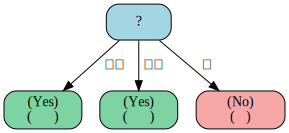

In [ ]:
# graphviz 라이브러리를 이용한 트리 시각화
import graphviz

# 트리 구조 정의 (DOT language)
dot_source = """
digraph WeatherTree {
    node [shape=box, style="filled, rounded", fillcolor="#e8f4f8"];
    edge [fontname="Helvetica"];

    // 루트 노드
    0 [label="날씨는?", fillcolor="#a1d6e2"];

    // 리프 노드
    1 [label="간다 (Yes)\n(맑음)", fillcolor="#7dd3a2"];
    2 [label="간다 (Yes)\n(흐림)", fillcolor="#7dd3a2"];
    3 [label="안간다 (No)\n(비)", fillcolor="#f8a7a7"];

    // 가지 (Branch)
    0 -> 1 [label="맑음"];
    0 -> 2 [label="흐림"];
    0 -> 3 [label=" 비 "];
}
"""
graph = graphviz.Source(dot_source)
graph # Colab에서 바로 시각화 결과를 보여줍니다.

**결정 트리 주요 용어 (위 그림 참고)**:
- **루트 노드(Root Node)**: 가장 처음 질문을 시작하는 맨 위 노드 ("날씨는?").
- **결정 노드(Decision Node)**: 데이터를 나누는 질문이 있는 중간 노드 (이 예시에서는 없음).
- **리프 노드(Leaf Node)**: 최종 결정(예측 결과)이 내려지는 맨 아래 끝 노드 ("간다", "안간다").
- **가지(Branch/Edge)**: 노드와 노드를 연결하며, 질문에 대한 답 ('맑음', '흐림', '비')을 나타냅니다.

이처럼 결정 트리는 각 단계에서 **정보 획득을 최대화**하는 질문을 찾아  
데이터를 반복적으로 분할하여 최종 예측 규칙을 만들어 나갑니다.

## 🌸 모듈 2: 단계별 결정 트리 모델링 (붓꽃 데이터)

이제 `scikit-learn`을 이용하여 붓꽃(Iris) 데이터셋으로 결정 트리 모델을 만들어 봅시다.  
이번에는 **꽃잎 길이(petal length)** 와 **꽃잎 너비(petal width)** 두 특징을 사용하여  
세 가지 품종(`setosa`, `versicolor`, `virginica`)을 모두 분류하는  
**다중 분류(Multi-class Classification)** 문제입니다.

다시 한번 머신러닝 워크플로우 5단계를 따라갑니다.

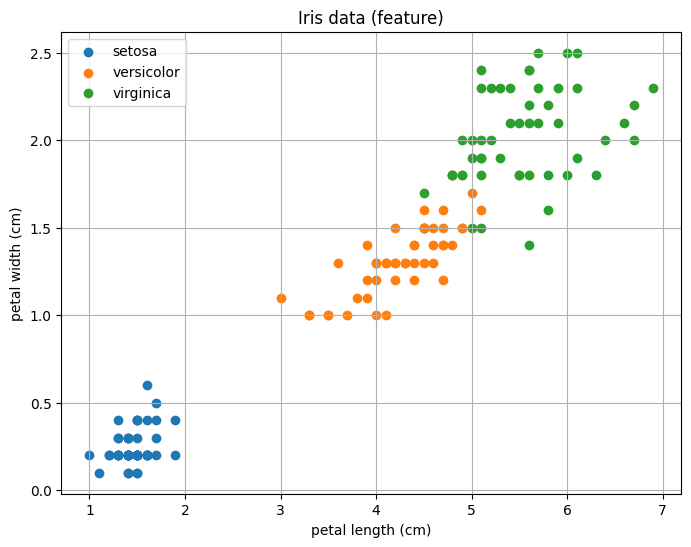

결과 해석:
- Setosa(파랑색)는 명확히 구분됩니다.
- Versicolor(주황색)와 Virginica(녹색)는 일부 겹쳐 보입니다.
- 직선 하나로는 세 품종을 완벽히 나누기 어려워 보입니다.


In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# DecisionTreeClassifier 를 불러옵니다.
from sklearn.tree import DecisionTreeClassifier
# 평가 지표 함수들을 불러옵니다.
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             classification_report)

# 1. 데이터 로드
iris = load_iris()

# 특징(X): 꽃잎 길이(2번), 꽃잎 너비(3번) -> 2개의 특징 사용!
X = iris.data[:, 2:4]
# 정답(y): 붓꽃 품종 (0, 1, 2)
y = iris.target
feature_names = iris.feature_names[2:]
        # 'petal length (cm)', 'petal width (cm)'
target_names = iris.target_names
        # 'setosa', 'versicolor', 'virginica'

# 2. 데이터 탐색 (시각화)
plt.figure(figsize=(8, 6))
# 품종(y)별로 다른 색상/마커로 산점도 표시
for i, target_name in enumerate(target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=target_name)

plt.title("Iris data (feature)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.grid(True)
plt.show()

print("결과 해석:")
print("- Setosa(파랑색)는 명확히 구분됩니다.")
print("- Versicolor(주황색)와 Virginica(녹색)는 일부 겹쳐 보입니다.")
print("- 직선 하나로는 세 품종을 완벽히 나누기 어려워 보입니다.")

다음으로, 데이터를 **연습 문제**와 **실전 시험**으로 분리합니다.  
다중 분류 문제이므로 `stratify` 옵션을 사용합니다.

In [ ]:
# 데이터를 '연습 문제'와 '실전 시험'으로 7:3 분리
# 다중 분류 문제이므로 stratify=y 옵션 사용
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")

Train 데이터 크기: (105, 2)
Test 데이터 크기: (45, 2)


이제 **결정 트리 모델**을 생성하고 **학습**시킵니다.

`DecisionTreeClassifier`의 주요 하이퍼파라미터:
- `criterion`: 불순도 측정 기준 ('gini' 또는 'entropy'). 기본값 'gini'.
- `max_depth`: 트리의 최대 깊이. `None`(기본값)이면 무제한 성장. (과적합 제어)
- `min_samples_split`: 노드를 나누기 위한 최소 샘플 수. 기본값 2. (과적합 제어)
- `min_samples_leaf`: 리프 노드가 되기 위한 최소 샘플 수. 기본값 1. (과적합 제어)
- `random_state`: 결과 재현을 위한 시드값.

In [ ]:
# 1. 결정 트리 모델 객체 생성
# random_state: 동일한 결과를 얻기 위해 난수 발생 시드 고정
# max_depth: 트리의 최대 깊이를 제한 (None이면 무제한 성장)
# -> 과적합 방지를 위한 중요한 하이퍼파라미터 (나중에 설명)
model_dt = DecisionTreeClassifier(random_state=42)

# 2. '연습 문제'로 모델 학습 (fit)
# 내부적으로 최적의 질문(특징/기준값)을 찾아가며
# 데이터를 분할하는 트리 구조를 만듭니다.
model_dt.fit(X_train, y_train)

print("결정 트리 모델 학습 완료!")

결정 트리 모델 학습 완료!


학습된 결정 트리의 **내부 구조**를 시각화하여  
모델이 어떤 질문들을 통해 데이터를 분류하는지 직접 확인할 수 있습니다.  
(`graphviz` 라이브러리 필요)

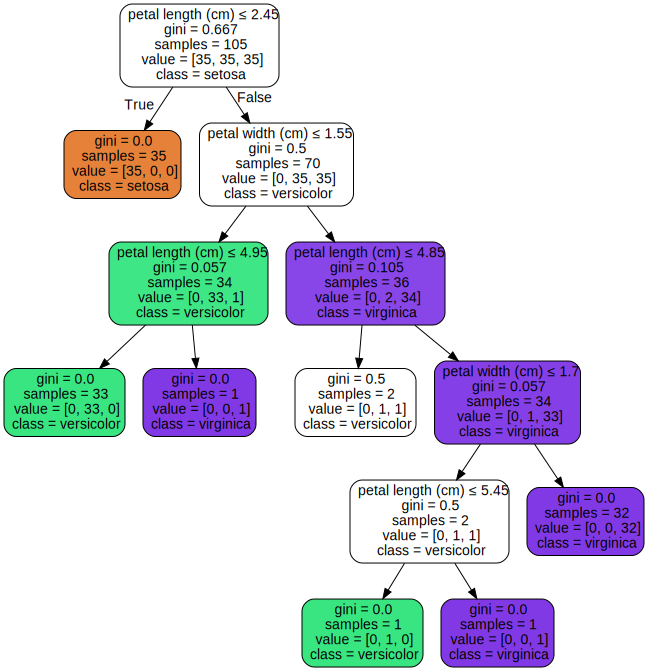

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
# 학습된 트리 구조 시각화
dot_data = export_graphviz(model_dt, out_file=None,
                           feature_names=feature_names,
                           class_names=target_names,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph # Colab에서 바로 시각화 결과를 보여줍니다.

학습된 트리가 **데이터 공간을 어떻게 나누는지(결정 경계)** 시각화해 봅시다.  
이를 통해 **과적합(Overfitting)** 의 징후를 확인할 수 있습니다.

과적합이란, 모델이 **연습 문제에 너무 특화**되어  
**실전 시험에서는 성능이 떨어지는 현상**을 말합니다.  
결정 트리는 제한 없이 성장하면 연습 데이터의 노이즈까지 학습하여  
매우 복잡한 결정 경계를 만들고 과적합되기 쉽습니다.

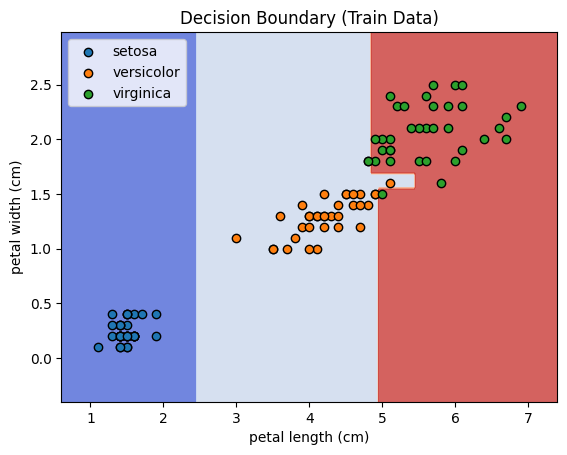

결과 해석:
- 연습 문제(Train Data)를 잘 분류하기 위해
  절묘한 결정 경계가 만들어졌습니다.
- 과적합(Overfitting)의 가능성이 있습니다.


In [ ]:
# 결정 경계 시각화 함수 정의 (이전 강의 내용 재사용)
def plot_decision_boundary(model, X, y, target_names, feature_names, title):
    plt.figure()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
    for i, target_name in enumerate(target_names):
        plt.scatter(X[y == i, 0], X[y == i, 1], label=target_name,
                    edgecolors='k')
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.show()

# 학습된 결정 트리 모델의 결정 경계 확인 (Train 데이터 기준)
plot_decision_boundary(model_dt, X_train, y_train, target_names,
                       feature_names, "Decision Boundary (Train Data)")

print("결과 해석:")
print("- 연습 문제(Train Data)를 잘 분류하기 위해")
print("  절묘한 결정 경계가 만들어졌습니다.")
print("- 과적합(Overfitting)의 가능성이 있습니다.")

--- 결정 트리 성능 평가 (Test Data) ---
정확도: 0.9333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



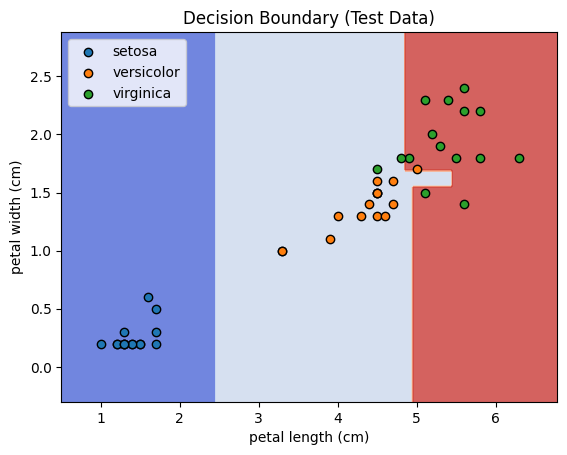

In [ ]:
# 결정 트리 모델 성능 평가 (Test 데이터 사용)
y_pred_dt = model_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, target_names=target_names)

print("--- 결정 트리 성능 평가 (Test Data) ---")
print(f"정확도: {accuracy_dt:.4f}")
print("\nClassification Report:")
print(report_dt)

# 결정 경계 시각화 (Test 데이터 기준)
plot_decision_boundary(model_dt, X_test, y_test, target_names,
                       feature_names, "Decision Boundary (Test Data)")

## 🌲 모듈 3: 과적합(Overfitting)과 랜덤 포레스트

### 결정 트리의 문제점: 과적합 (Overfitting)
- 결정 트리는 데이터를 완벽하게 나누기 위해 **너무 깊게 성장**하려는 경향이 있습니다.  
- 이는 **'연습 문제'는 100점**을 맞지만,  
약간 다른 형태의 **'실전 시험'은 잘 못 푸는** 현상으로 이어집니다.  
  (마치 시험 족보만 달달 외운 학생과 같습니다.)
- 위에서 본 복잡한 결정 경계가 바로 과적합의 징후일 수 있습니다.

**과적합 완화 방법**:
- `max_depth`: 트리의 최대 깊이 제한
- `min_samples_split`: 노드를 나누기 위한 최소 샘플 수 지정
- `min_samples_leaf`: 리프 노드가 가져야 할 최소 샘플 수 지정
- **앙상블(Ensemble) 기법 사용**


### 랜덤 포레스트 (Random Forest): 앙상블의 힘

결정 트리가 혼자서 모든 환자를 진단하는 **만능 의사**라고 해봅시다.  
이 의사는 자신이 본 환자들(학습 데이터)에게는 완벽한 진단(100점)을 내리지만,  
그 경험에 너무 특화된 나머지, 약간 다른 증상을 보이는 새로운 환자(테스트 데이터)에게는  
오히려 오진(과적합)을 내릴 위험이 있습니다.

**랜덤 포레스트**는 이런 문제를 해결하기 위해,  
한 명의 만능 의사 대신 **여러 명의 '조금씩 다른 전문의'** 들을 모아  
**의사 위원회(Committee)** 를 구성하는 것과 같습니다.  
➡️ 이 **의사의 수**가 바로 `RandomForestClassifier`의 **`n_estimators`** 파라미터입니다.

**어떻게 '조금씩 다른' 의사들을 만들까요? (Randomness!)**

1.  **서로 다른 환자 경험 (데이터 샘플링 - Bagging)**:
    - 전체 환자 기록(원본 데이터)에서 **무작위로 일부 환자 기록을 복원 추출**하여  
    각 의사에게 전달합니다.
    - 어떤 의사는 특정 환자를 여러 번 볼 수도 있고, 어떤 환자는 아예 못 볼 수도 있습니다.
    - 이렇게 하면 각 의사는 **조금씩 다른 환자 그룹**을 경험하게 됩니다.
    - ➡️ **`bootstrap=True`** (기본값) 파라미터가 이 방식을 사용함을 의미합니다.
    
2.  **집중하는 증상 제한 (특징 무작위 선택)**:
    - 각 의사가 진단(질문)을 내릴 때마다,  
    고려할 수 있는 **증상(특징)의 종류를 무작위로 제한**합니다.
    - 예를 들어, 어떤 의사는 '체온'과 '기침'만 보고 판단하고,  
    다른 의사는 '두통'과 '피로감'만 보고 판단하도록 강제합니다.
    - 이렇게 하면 각 의사는 **특정 증상 조합에 더 전문성**을 갖게 됩니다.
    - ➡️ **`max_features`** 파라미터가 이 단계를 제어합니다.   
(기본값 $\sqrt{n\_features}$)

**진단 과정 (예측)**:
- 새로운 환자가 오면, 위원회에 속한 **모든 의사들이 각자** 진단(예측)을 내립니다.  
  (각 의사는 자신이 경험한 환자들과 자신이 집중하도록 훈련받은 증상들을 바탕으로 판단합니다.)
- **최종 진단**: 모든 의사들의 진단 결과를 모아 **다수결 투표**를 합니다.  
가장 많은 표를 받은 진단명이 최종 결과가 됩니다.  
(회귀 문제의 경우 평균값을 사용)

**왜 더 효과적일까요?**

- 개별 의사들은 제한된 정보(다른 환자 경험, 일부 증상) 때문에 오진을 할 수도 있습니다.
- 하지만 **다양한 관점**을 가진 여러 의사들의 의견을 종합하면,  
**개별적인 실수들이 서로 상쇄**되어  
**전체적으로는 훨씬 더 정확하고 안정적인 진단**을 내릴 가능성이 높아집니다.
- 이것이 랜덤 포레스트가 단일 결정 트리보다 과적합에 강하고 일반화 성능이 뛰어난 이유입니다.

이제 **랜덤 포레스트 모델**을 생성하고 학습시켜  
결정 트리 모델과 성능을 비교해 봅시다.

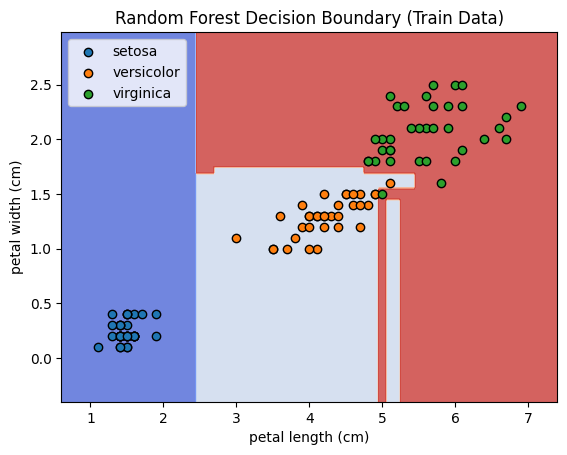

--- 랜덤 포레스트 성능 평가 (Test Data) ---
정확도: 0.9556

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.93      0.93      0.93        15
   virginica       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



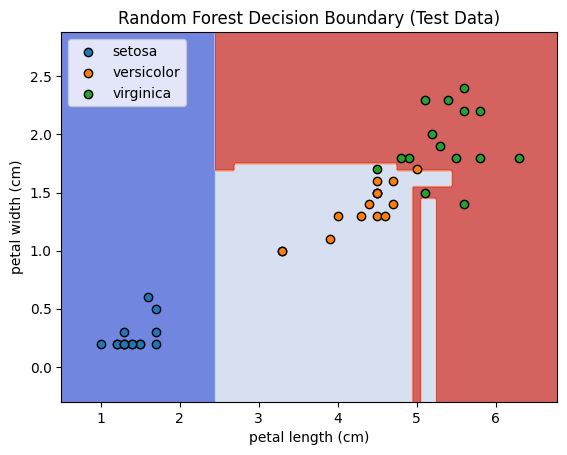


비교:
- 결정 트리 정확도: 0.9333
- 랜덤 포레스트 정확도: 0.9556

=> 과적합의 느낌이 없지는 않지만, 정확도가 약간 향상되었습니다.


In [ ]:
# 랜덤 포레스트 모델 임포트
from sklearn.ensemble import RandomForestClassifier

# 1. 랜덤 포레스트 모델 생성 및 학습
# n_estimators: 만들 트리의 개수 (의사의 수). 많을수록 좋지만 계산 시간 증가.
# random_state: 결과 재현을 위한 시드값.
model_rf = RandomForestClassifier(n_estimators=15, random_state=42)
model_rf.fit(X_train, y_train)
plot_decision_boundary(model_rf, X_train, y_train, target_names,
                       feature_names, "Random Forest Decision Boundary (Train Data)")

# 2. 랜덤 포레스트 모델 성능 평가 (Test 데이터 사용)
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, target_names=target_names)

print("--- 랜덤 포레스트 성능 평가 (Test Data) ---")
print(f"정확도: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(report_rf)

# 결정 경계 시각화 (Test 데이터 기준)
plot_decision_boundary(model_rf, X_test, y_test, target_names,
                       feature_names, "Random Forest Decision Boundary (Test Data)")

print("\n비교:")
print(f"- 결정 트리 정확도: {accuracy_dt:.4f}")
print(f"- 랜덤 포레스트 정확도: {accuracy_rf:.4f}")
print("\n=> 과적합의 느낌이 없지는 않지만, 정확도가 약간 향상되었습니다.")

랜덤 포레스트는 각 특징이 모델 예측에 얼마나 중요한 역할을 했는지 알려주는  
**특징 중요도(Feature Importance)** 정보를 제공합니다.

In [ ]:
# (참고) 특징 중요도 확인
# model_rf 객체의 feature_importances_ 속성에 저장되어 있음
importances = model_rf.feature_importances_
print("\n--- 특징 중요도 (Feature Importances) ---")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")
print("\n=> 이 문제에서는 꽃잎 너비(petal width)가 품종 분류에")
print("   꽃잎 길이(petal length)보다 약간 더 중요한 특징임을 알 수 있습니다.")


--- 특징 중요도 (Feature Importances) ---
petal length (cm): 0.5217
petal width (cm): 0.4783

=> 이 문제에서는 꽃잎 너비(petal width)가 품종 분류에
   꽃잎 길이(petal length)보다 약간 더 중요한 특징임을 알 수 있습니다.


## ✨ 마무리

오늘은 비선형 문제를 해결하는 강력한 도구인  
**결정 트리**와 **랜덤 포레스트**를 배웠습니다.

- **결정 트리**: 스무고개처럼 질문하며 데이터를 분할. 직관적이지만 과적합 위험.
- **랜덤 포레스트**: 여러 결정 트리를 활용한 앙상블 기법. 과적합을 줄이고 성능 향상.

다음 시간에는 정답 없이 데이터의 숨겨진 구조를 찾는  
**비지도 학습**의 대표 주자, **K-Means 군집화(Clustering)** 에 대해 알아보겠습니다.

```

































```



































